In [1]:
"""
Modified this notebook to include prior stuff.
"""

#data
import numpy as np
import pandas as pd
import pdfplumber
import xarray as xr
from pathlib import Path
from typing import Dict, Any


# plotting
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
sns.set_style("whitegrid")

#Bayes
import pymc as pm
import arviz as az
import pytensor.tensor as pt

#Make sure it can see the system path
from pathlib import Path
import sys

# Add parent directory of the notebook (the project root) to sys.path
ROOT = Path().resolve().parent   # X/
sys.path.insert(0, str(ROOT))

#Other modules
from bayes import data_utils
from bayes import DATA_DIR


In [2]:
# Debugging
import importlib
importlib.reload(data_utils)

<module 'bayes.data_utils' from '/Users/omard/Documents/projects/TCRE_Assessment/bayes/data_utils.py'>

In [3]:
coords=data_utils.get_coords()
coords

{'process': ['nitrogen', 'fire', 'vegetation'],
 'model': array(['ACCESS-ESM1-5', 'BCC-CSM2-MR', 'CanESM5', 'CESM2', 'CNRM-ESM2-1',
        'GFDL-ESM4', 'IPSL-CM6A-LR', 'MIROC-ES2L', 'MPI-ESM1-2-LR',
        'NorESM2-LM', 'UKESM1-0-LL', 'EC-Earth3-CC', 'CMCC-ESM2'],
       dtype=object),
 'parameter': ['βL', 'γL'],
 'cross_parameter': ['βL', 'γL']}

# Load the evidence

In [4]:
process_evidence=data_utils.load_process_evidence(kind="2xCO2")
emergent_contraint_evidence=data_utils.load_emergent_constraint_evidence()
cmip_evidence=data_utils.load_CMIP_land_data(kind="2xCO2")
evidence = process_evidence | emergent_contraint_evidence | cmip_evidence

# Set the priors

In [5]:
beta_gamma_priors={"βL":lambda name: pm.Uniform(name,0,10),\
       "γLX": lambda name: pm.Normal(name,-100,100),\
       "γLT": lambda name: pm.Normal(name,-100,100)}

# process priors

beta_scaling_priors={"η_nitrogen": lambda name: pm.Uniform(name,0.001,1),\
            "η_fire": lambda name: pm.Uniform(name,0.001,2),\
            "δβ_permafrost": lambda name: pm.Normal(name,1.0,.00001),\
            "η_vegetation": lambda name: pm.Uniform(name,0.001,2)}

gamma_scaling_priors={"ν_nitrogen": lambda name: pm.Uniform(name,0.001,1),\
            "ν_fire": lambda name: pm.Uniform(name,0.001,2),\
            "δγ_permafrost": lambda name: pm.Normal(name,-100.0,100),\
            "ν_vegetation": lambda name: pm.Uniform(name,0.001,2)}

proc_priors=beta_scaling_priors | gamma_scaling_priors

priors = beta_gamma_priors | proc_priors

# Set the hyperpriors (Or use defaults)
You can think of these as nuisances: they apply to parameters in the forward models we use to make sense of our evidence.  

In [6]:
#Assume model spread in scaling is the same for every process
#This is the PRECISION: 1/sigma (for numerical stability)
#The bigger it is the more representative a single process-based run will be
hyperpriors_process={"τ_eta": lambda name: pm.HalfNormal(name,0.5),\
            "τ_nu": lambda name: pm.HalfNormal(name,0.5)}

# Priors on the slope and y-intercept of the emergent constraint line
hyperpriors_ec = {'m': lambda name: pm.Normal(name,0,10),
        'b': lambda name: pm.Normal(name,0,10)}

# Priors on CMIP model structural spread
hyperpriors_cov = {"chol": lambda name: pm.LKJCholeskyCov(
    name,
    n=len(coords["parameter"]),
    eta=2.0,         # Strength of the LKJ prior; 1 = uniform over correlations
    sd_dist=pm.HalfNormal.dist(1.0)
            )}

hyperpriors = hyperpriors_process | hyperpriors_ec | hyperpriors_cov


# Validate the priors
Make sure we've specified everything we need

In [7]:
data_utils.validate_priors(priors,hyperpriors=hyperpriors)

## Use the single-process runs to estimate the scaling factor
Right now we don't know much about the scaling factors because we don't have very many process runs.  The posteriors on $\nu$ and $\gamma$ for each process are going to depend very strongly on two things: 
* our priors on the scaling factors
* how much model spread in the scaling factors we expect there to be

The former is controlled by our physical intuition, as specified above.  The latter is controlled by the $\tau$ parameter.  If the model spread in the scaling factor is assumed to be small, then even a single process-based run will be very informative about the scaling factor.  If it's big, then a single process-based run tells us almost nothing at all.

The more single-process runs we get, the more we can constrain both the scaling factor and the model spread.

### Caveats

* Right now I assume no cross-correlations between $\eta$ and $\nu$. It might be reasonable (if more complicated) to assume a model with large $\eta_{N}$ (or whatever) also has large $\gamma_N$.
* I assume a single $\tau_{\nu}$ or $\tau_{\beta}$ for every process.

## Mathematical model
We assume that for each process $j$ (where $j$ is one of ["nitrogen","fire","vegetation"]) the single-process evidence from ESM $i$ is 
$$\eta_{j}^i \sim N(\eta_{j},\tau_{\eta}^{-1})$$
and 
$$\nu_{j}^i \sim N(\nu_{j},\tau_{\nu}^{-1})$$
where $\eta_j$ and $\nu_j$ are the true real-world values of the scaling factors associated with process $j$.

In [8]:
def make_process_model(model,evidence,priors,hyperpriors):


    with model:
        for k,values in coords.items():
            if k not in model.coords:
                model.add_coord(k,values)
        etalist=[]
        for process in coords["process"]:
            etalist+=[priors[f"η_{process}"](name=f"η_{process}")]
        eta = pm.Deterministic("η",pm.math.stack(etalist),dims=("process",))


        #Assume model spread is the same for every process
        #This is the PRECISION: 1/sigma
        #The bigger it is the more representative a single process-based run will be
       
        tau_eta=hyperpriors["τ_eta"](name="τ_eta")
        tau_nu=hyperpriors["τ_nu"](name="τ_nu")
        #Now update the posteriors for eta_process with the process ensembles
        for k,process in enumerate(coords["process"]):
            pm.Normal("lik_eta_"+process,eta[k],tau=tau_eta,observed=evidence[f"η_{process}"])


        nulist=[]
        for process in coords["process"]:
            nulist+=[priors[f"ν_{process}"](name=f"ν_{process}")]
        nu = pm.Deterministic("ν",pm.math.stack(nulist),dims=("process",))

    # Assume common spread tau_process
    #Now update the posteriors for eta_process with the process ensembles
        for k,process in enumerate(coords["process"]):
            pm.Normal("lik_nu_"+process,nu[k],tau=tau_nu,observed=evidence[f"ν_{process}"])    
    return {"ν":nu,"η":eta, "τ_eta":tau_eta,"τ_nu":tau_nu}

In [9]:
with pm.Model() as test_process_model:
    params=make_process_model(test_process_model,evidence,priors,hyperpriors)
    test_process_trace=pm.sample()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [η_nitrogen, η_fire, η_vegetation, τ_eta, τ_nu, ν_nitrogen, ν_fire, ν_vegetation]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


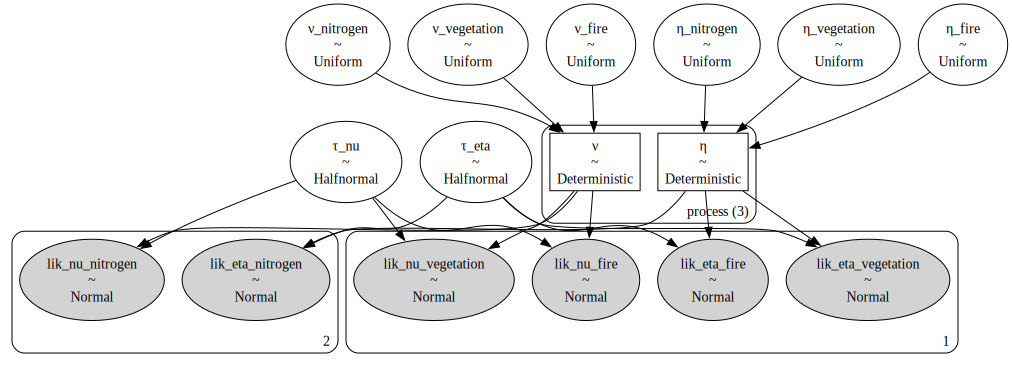

In [10]:
pm.model_to_graphviz(test_process_model)


In [11]:
with pm.Model() as test_process_model:
    params=make_process_model(test_process_model,evidence,priors,hyperpriors)
    idata=pm.sample(5000)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [η_nitrogen, η_fire, η_vegetation, τ_eta, τ_nu, ν_nitrogen, ν_fire, ν_vegetation]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 2 seconds.


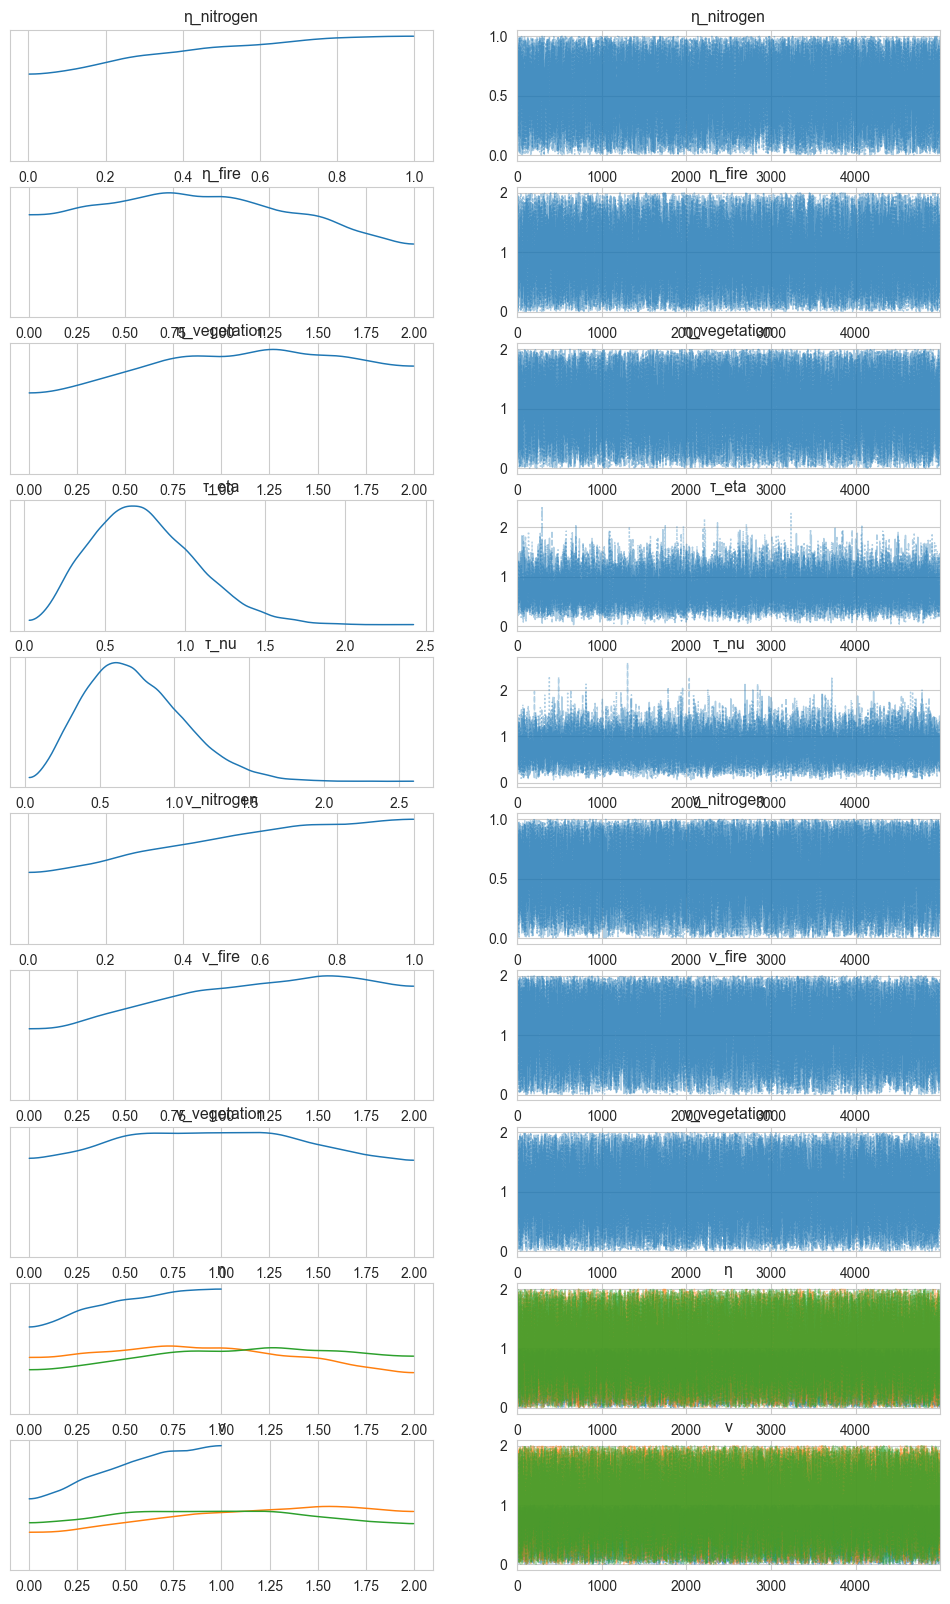

In [12]:
az.plot_trace(idata, combined=True);

### Playing with new module

In [13]:
from bayes.priors_config import get_prior_config, PriorConfiguration

#here, we just use the default configuration
config = get_prior_config("default")
config

PriorConfiguration(scenario='default', n_priors=11, n_hyperpriors=5)

In [14]:
#you can also print the prior summary
print(config.summary())


PRIOR CONFIGURATION: default

PRIORS:
--------------------------------------------------------------------------------
βL                   uniform              {'lower': 0, 'upper': 10}     
                     Baseline land carbon uptake response to CO2
                     Source: Default range

γLT                  normal               {'mu': -100, 'sigma': 100}    
                     Gamma tropical long-term
                     Source: Wide uninformative prior

γLX                  normal               {'mu': -100, 'sigma': 100}    
                     Gamma extratropical
                     Source: Wide uninformative prior

η_nitrogen           uniform              {'lower': 0.001, 'upper': 1.0}
                     Beta scaling for nitrogen cycle (0 to 1, reduces CO2 fertilization)
                     Source: Nov 14, 2025 discussion: Pierre noted gamma could be -ve

ν_nitrogen           uniform              {'lower': 0.001, 'upper': 1.0}
                     Gamma scalin

In [15]:
missing_priors, missing_hyperpriors = config.validate()
if missing_priors or missing_hyperpriors:
    raise ValueError(
        f"Missing priors: {missing_priors}\n"
        f"Missing hyperpriors: {missing_hyperpriors}"
    )

In [16]:
priors, hyperpriors = config.to_pymc_dict()

In [17]:
with pm.Model() as process_model_new:
     params = make_process_model(process_model_new, evidence, priors, hyperpriors)
     trace = pm.sample(5000)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [η_nitrogen, η_fire, η_vegetation, τ_eta, τ_nu, ν_nitrogen, ν_fire, ν_vegetation]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 2 seconds.


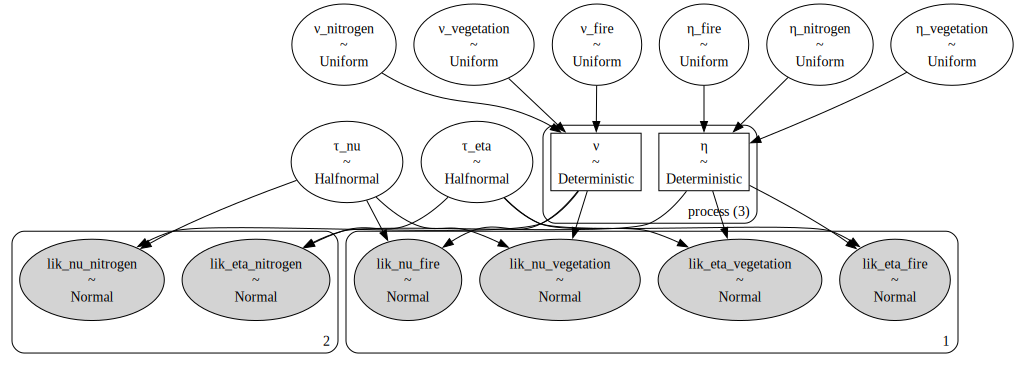

In [18]:
#same as before
pm.model_to_graphviz(process_model_new)


In [19]:
with pm.Model() as test_process_model_new:
    params=make_process_model(test_process_model_new,evidence,priors,hyperpriors)
    idata=pm.sample(5000)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [η_nitrogen, η_fire, η_vegetation, τ_eta, τ_nu, ν_nitrogen, ν_fire, ν_vegetation]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 2 seconds.


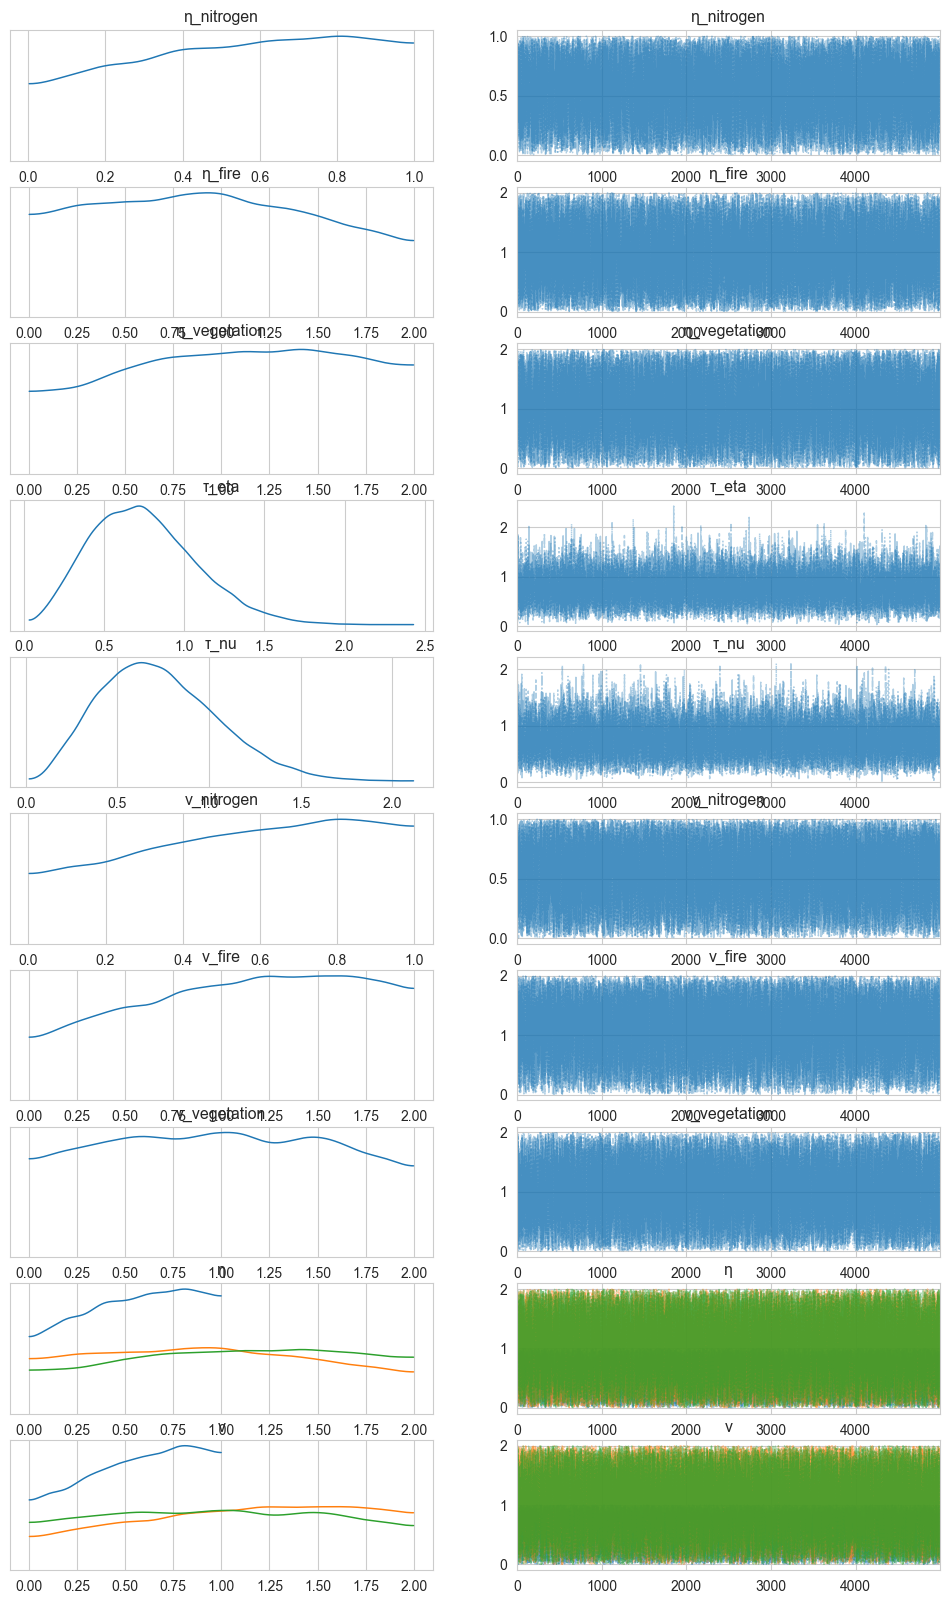

In [20]:
az.plot_trace(idata, combined=True);

# Emergent constraint model
We use a standard errors-in-variables regression to estimate the slope and y-intercept of the regression between (uncertain) tropical gamma land and (uncertain) interannual variability.  We also take into account the uncertainty in the observed interannual variability.

In [13]:
def make_emergent_constraint_model(model,evidence,priors,hyperpriors):
    with model:
        ### EMERGENT CONSTRAINT ###
        # EMERGENT CONSTRAINT ON TROPICAL γLT
        n_models_EC=len(evidence['γ_LT'])
        γLT=priors["γLT"](name="γLT")
            #Assume linear relationships
        # Hyperpriors on slope and intercept
        m = hyperpriors["m"](name="m")
        b = hyperpriors["b"](name="b")

        # Errors-in-variables model for model gammaLT- use standard deviations reported by Zechlau
        x_true = pm.Normal("x_true", mu=evidence['γ_LT'], \
                           sigma=evidence['σ_LT'], \
                           shape=n_models_EC)

        # Linear model for "true IAV" values
        y_true = m * x_true + b

        # Likelihood of observed IAV values
        y_likelihood = pm.Normal("y_obs", mu=y_true, \
                                 sigma=evidence['σ_IAV'],\
                                 shape=n_models_EC,\
                                 observed=evidence['γ_IAV'])
        #Emergent constraint relationship

        mu_obs = m * γLT + b
        # IAV observed ~ N(-4.3,0.67) #CHECK IF THIS IS ONE OR TWO SIGMA
        IAV_true=pm.Normal("IAV_true",mu=mu_obs,\
                           sigma=evidence["IAV_observed_std"],\
                           observed = [evidence["IAV_observed_mean"]])
        return {"γLT":γLT}

In [14]:
with pm.Model() as ec_test_model:
    test=make_emergent_constraint_model(ec_test_model,emergent_contraint_evidence,priors,hyperpriors)
    ec_test_trace=pm.sample()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [γLT, m, b, x_true]


/Users/omard/Documents/envs/wmo/lib/python3.12/site-packages/rich/live.py:256: UserWarning: install "ipywidgets" 
for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


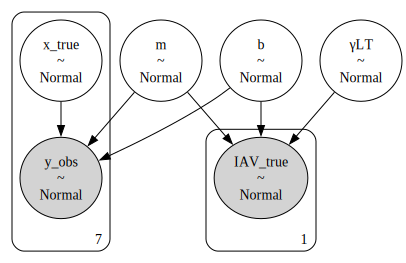

In [15]:
pm.model_to_graphviz(ec_test_model)

In [25]:
#D must have dimensions (Nmodels,2)

D=np.stack([evidence["βL_cmip"],evidence["γL_cmip"]]).T


#def covariance_model(model):
with pm.Model() as bigmodel:

    ########
    #get eta, nu, tau_eta, tau_nu from the process model
    #######
    process_model=make_process_model(bigmodel,
                                     evidence,
                                     priors,
                                     hyperpriors)
    eta=process_model["η"]
    nu=process_model["ν"]
    tau_eta=process_model["τ_eta"]
    tau_nu=process_model["τ_nu"]
    
    ## Add the CMIP data in the form of mutable data
    CMIP = pm.Data("CMIP",D)
    
    
    
    for k,values in coords.items():
            if k not in bigmodel.coords:
                bigmodel.add_coord(k,values)
        
    # Prior on gamma_extratropics
    gamma_extratropics=priors["γLX"](name="γLX")
    # Get gamma tropics from the emergent constraint model
    emergent_constraint_model=make_emergent_constraint_model(bigmodel,\
                                                             evidence,\
                                                             priors,\
                                                             hyperpriors)
    gamma_tropics=emergent_constraint_model["γLT"]
    
    # The total gamma is the sum of extratropics and tropics
    gamma = pm.Deterministic("γL",gamma_extratropics+gamma_tropics)
    # and the prior on beta
    beta=priors["βL"](name="βL")
    mu=pm.Deterministic("μ",pm.math.stack([beta,gamma]),dims=("parameter",))
    
    # Prior on Cholesky decomposition of covariance matrix (has to be LKJ)
    # sd_dist gives priors for standard deviations
    #Make these really wide if you like- reflects model structural spread
    chol, corr, sigma = hyperpriors["chol"](name="chol")

    
    # Construct covariance matrix from Cholesky
    Sigma = pm.Deterministic("Sigma", chol.dot(chol.T),dims=("parameter","cross_parameter"))
   
    #get eta for each model
     
    
    Eta_arr = pt.ones((len(coords["process"]), len(coords["model"])))
    Nu_arr = pt.ones((len(coords["process"]), len(coords["model"])))
    
    for j in range(len(coords["process"])):
        # Use pm.math.switch to multiply by eta[j] only where lookup_table[j, :] == 1
        Eta_arr = pt.set_subtensor(Eta_arr[j, :], 
                                          pm.math.switch(pt.eq(evidence["lookup table"][j, :], 1), eta[j], 1.0))
        Nu_arr = pt.set_subtensor(Nu_arr[j, :], 
                                         pm.math.switch(pt.eq(evidence["lookup table"][j, :], 1), nu[j], 1.0))
    
    # Unscaled B
    
    B = beta / pm.math.prod(eta)
    G = gamma / pm.math.prod(nu)
 
    
    # Do mu
    mu_model=[]
    for i,model in enumerate(coords["model"]):
       
        eta_model=pm.math.prod(Eta_arr[:,i])
        nu_model=pm.math.prod(Nu_arr[:,i])
        mu_model+=[pm.math.stack([eta_model*B,nu_model*G])]
    mu_totals = pm.Deterministic("all_mus",
                                 pm.math.stack([mu_model[i] for i,model in enumerate(coords["model"])]),
                                              dims=("model","parameter"))
    
    pm.MvNormal(f'D', mu=mu_totals, chol=chol, observed=CMIP)
    covtrace=pm.sample(target_accept=.99)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [η_nitrogen, η_fire, η_vegetation, τ_eta, τ_nu, ν_nitrogen, ν_fire, ν_vegetation, γLX, γLT, m, b, x_true, βL, chol]


/Users/omard/Documents/envs/wmo/lib/python3.12/site-packages/rich/live.py:256: UserWarning: install "ipywidgets" 
for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 72 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
